# Franke Function Regression problem with PyTorch

In [23]:
import torch as torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torcheval.metrics import R2Score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
plt.rcParams.update({'text.usetex': True, 'font.size': 16, 'font.family': 'serif', 'font.serif': 'Computer Modern Sans Serif', 'font.weight': 100, 'mathtext.fontset': 'cm', 'xtick.labelsize': 14, 'ytick.labelsize': 14})

from utils import FrankeFunction

plt.style.use('seaborn-darkgrid')

C:\Users\Erik\AppData\Local\Temp\ipykernel_58944\1243502911.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [4]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [5]:
N  = 100

x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
yy, xx = np.meshgrid(x, y)

zz = FrankeFunction(xx, yy, 0.01)
target = zz.reshape(-1,1)

In [8]:
#Concatenate date & tensor-transform
data = np.concatenate((xx.flatten().reshape(-1,1), yy.flatten().reshape(-1,1)), axis=1)
data = torch.tensor(data, dtype=torch.float32)
Z = torch.tensor(target, dtype=torch.float32)

#Define the initialization
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.1)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

#Define NN architecture
class Network(nn.Module):
    def __init__(self, input_size=2):
        super(Network, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(self.input_size, 50),
            nn.Sigmoid(),
            nn.Linear(50, 25),
            nn.Sigmoid(),
            nn.Linear(25, 1))

        self.network.apply(initialize_weights)

    def forward(self, x):
        return self.network(x)

In [11]:
model = Network(2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss = nn.MSELoss()
num_epochs = 2000
batch_size = 32
loss_evolution = []
r2_evolution = []
metric = R2Score()

#Random shuffling
perm = torch.randperm(data.size()[0])
data = data[perm]
Z = Z[perm]

#Training
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i+batch_size]
        batch_target = Z[i:i+batch_size]

        optimizer.zero_grad()
        output = model(batch_data)
        loss_value = loss(output, batch_target)
        loss_value.backward()
        optimizer.step()

    model.eval()
    output = model(data)
    loss_value = loss(output, Z)
    metric.update(output, Z)
    metric_value = metric.compute()

    loss_evolution.append(loss_value.item())
    r2_evolution.append(metric_value)
    if epoch % 150 == 0:
        print(f'Epoch {epoch} | Loss: {loss_value.item()} | R2 Score {metric_value}')
    metric.reset()

Epoch 0 | Loss: 0.08161977678537369 | R2 Score 0.011369466781616211
Epoch 150 | Loss: 0.021190039813518524 | R2 Score 0.7433328032493591
Epoch 300 | Loss: 0.019840402528643608 | R2 Score 0.759680449962616
Epoch 450 | Loss: 0.014726174995303154 | R2 Score 0.8216272592544556
Epoch 600 | Loss: 0.006549316458404064 | R2 Score 0.9206705093383789
Epoch 750 | Loss: 0.004431512206792831 | R2 Score 0.9463227391242981
Epoch 900 | Loss: 0.003229993162676692 | R2 Score 0.9608762860298157
Epoch 1050 | Loss: 0.0029806073289364576 | R2 Score 0.9638969898223877
Epoch 1200 | Loss: 0.002809182507917285 | R2 Score 0.9659733772277832
Epoch 1350 | Loss: 0.002659774385392666 | R2 Score 0.9677830934524536
Epoch 1500 | Loss: 0.002518276683986187 | R2 Score 0.96949702501297
Epoch 1650 | Loss: 0.002374335890635848 | R2 Score 0.9712405204772949
Epoch 1800 | Loss: 0.0022136764600872993 | R2 Score 0.9731865525245667
Epoch 1950 | Loss: 0.0020132362842559814 | R2 Score 0.9756144285202026


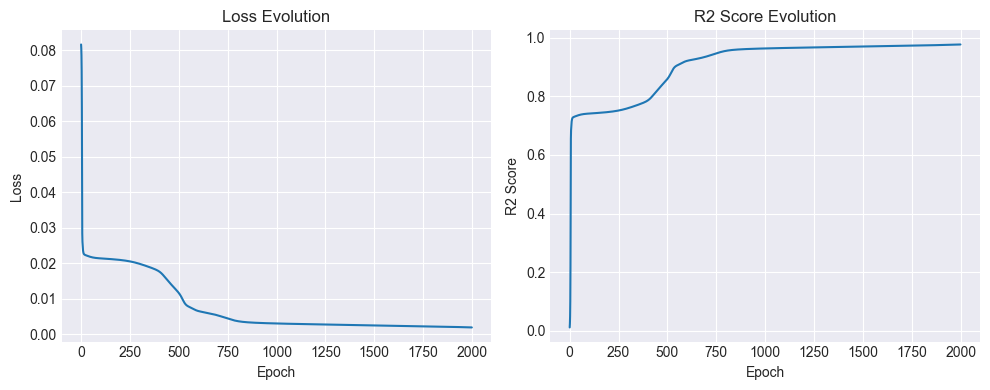

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(loss_evolution)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Evolution')

ax[1].plot(r2_evolution)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('R2 Score')
ax[1].set_title('R2 Score Evolution')

plt.tight_layout()
plt.savefig("../nn_torch_franke.pdf")
plt.show()


# Breast Cancer Classification problem with PyTorch

In [15]:
data = load_breast_cancer()
X = data.data
y = data.target
y_names = data.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
#Transform to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

#Define the initialization
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.1)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

#Define NN architecture
class Network(nn.Module):
    def __init__(self, input_size):
        super(Network, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(self.input_size, 10),
            nn.Sigmoid(),
            nn.Linear(10, 5),
            nn.Sigmoid(),
            nn.Linear(5, 2),
            )

        self.network.apply(initialize_weights)

    def forward(self, x):
        return self.network(x)

#Define the Accuracy function
def accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    total = target.size(0)
    return correct / total

In [18]:
#Model definition
model = Network(X.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()
num_epochs = 2000
batch_size = 32

#Store metrics evolution
train_loss_evolution = []
train_accuracy_evolution = []
test_loss_evolution = []
accuracy_evolution = []

#Training
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        batch_data = X_train[i:i+batch_size]
        batch_target = y_train[i:i+batch_size]

        optimizer.zero_grad()
        output = model(batch_data)

        loss_value = loss(output, batch_target)
        loss_value.backward()
        optimizer.step()

    #Evaluate on train dataset
    model.eval()
    output = model(X_train)
    loss_value = loss(output, y_train)
    train_loss_evolution.append(loss_value.item())
    train_accuracy_evolution.append(accuracy(output, y_train))

    #Evaluate on test dataset
    output = model(X_test)
    loss_value = loss(output, y_test)
    test_loss_evolution.append(loss_value.item())
    accuracy_evolution.append(accuracy(output, y_test))

    if epoch % 100 == 0:
        print(f'Epoch {epoch} | Train Loss: {train_loss_evolution[-1]} | Train Accuracy: {train_accuracy_evolution[-1]} | Test Loss: {test_loss_evolution[-1]} | Test Accuracy: {accuracy_evolution[-1]}')


Epoch 0 | Train Loss: 0.6772247552871704 | Train Accuracy: 0.6285714285714286 | Test Loss: 0.6779773831367493 | Test Accuracy: 0.6228070175438597
Epoch 100 | Train Loss: 0.6476906538009644 | Train Accuracy: 0.6285714285714286 | Test Loss: 0.6504489183425903 | Test Accuracy: 0.6228070175438597
Epoch 200 | Train Loss: 0.5295414924621582 | Train Accuracy: 0.6615384615384615 | Test Loss: 0.5270617604255676 | Test Accuracy: 0.6754385964912281
Epoch 300 | Train Loss: 0.19805538654327393 | Train Accuracy: 0.9604395604395605 | Test Loss: 0.1798226237297058 | Test Accuracy: 0.9649122807017544
Epoch 400 | Train Loss: 0.10758639872074127 | Train Accuracy: 0.9802197802197802 | Test Loss: 0.09425858408212662 | Test Accuracy: 0.9912280701754386
Epoch 500 | Train Loss: 0.08143864572048187 | Train Accuracy: 0.9846153846153847 | Test Loss: 0.07347895950078964 | Test Accuracy: 0.9824561403508771
Epoch 600 | Train Loss: 0.07004135102033615 | Train Accuracy: 0.9824175824175824 | Test Loss: 0.0653453022241

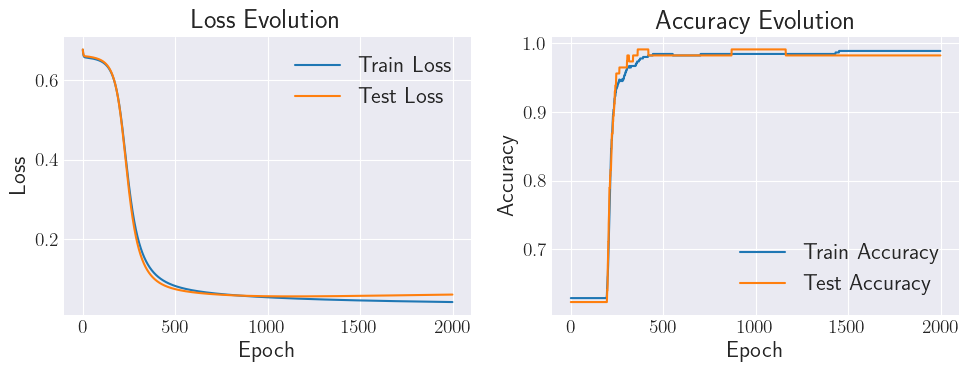

In [19]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(train_loss_evolution, label='Train Loss')
ax[0].plot(test_loss_evolution, label='Test Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Evolution')
ax[0].legend()

ax[1].plot(train_accuracy_evolution, label='Train Accuracy')
ax[1].plot(accuracy_evolution, label='Test Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Evolution')
ax[1].legend()

plt.tight_layout()
plt.savefig("../nn_torch_breast_cancer.pdf")
plt.show()

# Logistic Regression with Skicit-learn

In [24]:
data = load_breast_cancer()
X = data.data
y = data.target
y_names = data.target_names

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
logistic_regression = LogisticRegression(max_iter=1000, solver='lbfgs')
logistic_regression.fit(X_train, y_train)

#Evaluate the model
train_accuracy = logistic_regression.score(X_train, y_train)
test_accuracy = logistic_regression.score(X_test, y_test)
print(f'Actual data\nTrain accuracy: {train_accuracy}')
print(f'Test accuracy: {test_accuracy} \n')

#Again with scaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
logistic_regression.fit(X_train_scaled, y_train)
train_accuracy = logistic_regression.score(X_train_scaled, y_train)
test_accuracy = logistic_regression.score(X_test_scaled, y_test)
print(f'Scaled data\nTrain accuracy: {train_accuracy}')
print(f'Test accuracy: {test_accuracy}\n')

#Cross validation
scores = cross_validate(logistic_regression, X, y, cv=10)['test_score']
print(f'Cross validation scores: {scores}')

C:\Users\Erik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Actual data
Train accuracy: 0.9604395604395605
Test accuracy: 0.956140350877193 

Scaled data
Train accuracy: 0.9868131868131869
Test accuracy: 0.9736842105263158



C:\Users\Erik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Erik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Cross validation scores: [0.94736842 0.9122807  0.92982456 0.94736842 0.96491228 0.98245614
 0.92982456 0.94736842 0.96491228 0.96428571]


C:\Users\Erik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Confusion matrix:
[[41  2]
 [ 1 70]]


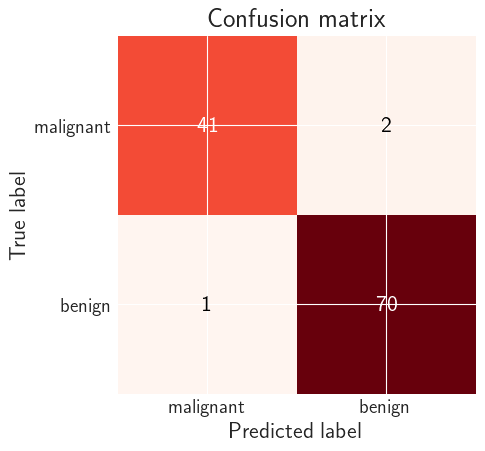

In [31]:
# Compute and plot the confusion matrix

from sklearn.metrics import confusion_matrix
y_pred = logistic_regression.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
print(f'\nConfusion matrix:\n{cm}')

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=y_names, yticklabels=y_names,
       title='Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white"
                if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
plt.savefig("../figs/confusion_matrix.pdf")
plt.show()